**Bibliotecas**

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

**Carregamento dos dados**

In [29]:
train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")

print(train.shape, test.shape)

(517754, 14) (172585, 13)



**EDA - Visualizações (gráficos, histogramas, boxplots, correlações)Estatísticas descritivasIdentificação de outliersDetecção de valores ausentesCompreensão da distribuição das variáveis******


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

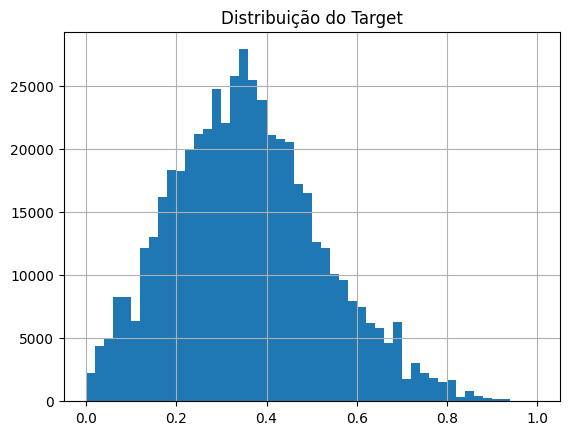

In [15]:
train.head()
train.info()
train["accident_risk"].hist(bins=50)
plt.title("Distribuição do Target")
plt.show()

**Identificar target e features**

In [16]:
TARGET = "accident_risk"

X = train.drop(columns=[TARGET, "id"])
y = train[TARGET]
X_test = test.drop(columns=["id"])

**Tratar valores faltantes corretamente**

In [17]:
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].fillna("Unknown")
        X_test[col] = X_test[col].fillna("Unknown")
    else:
        med = X[col].median()
        X[col] = X[col].fillna(med)
        X_test[col] = X_test[col].fillna(med)

**Encoding categórico**

In [18]:
cat_cols = X.select_dtypes(include="object").columns

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])


**Feature Engineering (melhor parte)**

In [19]:
def add_features(df):

    # binning de distância
    if "distance_km" in df:
        df["distance_bin"] = pd.cut(
            df["distance_km"],
            bins=[0, 30, 100, 200, 500, 2000],
            labels=[0, 1, 2, 3, 4]
        ).astype(int)

    # interação clima x tipo de veículo
    if "weather" in df and "vehicle_type" in df:
        df["weather_vehicle"] = df["weather"].astype(str) + "_" + df["vehicle_type"].astype(str)

    return df

X = add_features(X)
X_test = add_features(X_test)

# encoding para novas features categóricas
for col in X.select_dtypes(include="object").columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    X_test[col] = le.transform(X_test[col])


**Inicializar modelos estáveis✔️ CatBoost — tende a ser o melhor em tabular**


In [20]:
cat_model = CatBoostRegressor(
    iterations=1200,
    learning_rate=0.03,
    depth=6,
    loss_function="RMSE",
    random_seed=42
)
   

**✔️ LightGBM — rápido e forte**

In [21]:
lgb_model = LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [22]:
print(lgb_model)

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=1500,
              random_state=42, subsample=0.8)


**Validação KFold + Treinamento + Predições**

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cat_oof = np.zeros(len(X))
lgb_oof = np.zeros(len(X))

cat_preds = np.zeros(len(X_test))
lgb_preds = np.zeros(len(X_test)) 

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # === CatBoost ===
    cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    cat_oof[val_idx] = cat_model.predict(X_val)
    cat_preds += cat_model.predict(X_test) / kf.n_splits


**Medir estabilidade e RMSE**

In [24]:
rmse_cat = mean_squared_error(y, cat_oof, squared=False)
rmse_lgb = mean_squared_error(y, lgb_oof, squared=False)

print("RMSE CatBoost:", rmse_cat)
print("RMSE LightGBM:", rmse_lgb)

RMSE CatBoost: 0.05617343542404422
RMSE LightGBM: 0.38969788603477434


**Ensemble (média ponderada) — quase sempre melhora**

In [27]:
final_preds = 0.6 * cat_preds + 0.4 * lgb_preds

**Criar arquivo de submissão**

In [31]:
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e10/sample_submission.csv")


In [33]:
submission = sample_submission.copy()
submission["accident_risk"] = final_preds
submission.to_csv("submission.csv", index=False)

submission.head()


,id,accident_risk
0,517754,0.175907
1,517755,0.073492
2,517756,0.113666
3,517757,0.192488
4,517758,0.239383
